In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import mne
import pathlib
import sklearn
import seaborn as sns
from meegkit import dss
 
from pycrostates.preprocessing import extract_gfp_peaks
from neurokit2.microstates.microstates_clean import microstates_clean
from mne_icalabel import label_components
from scipy.stats import kurtosis, skew

In [2]:
from eeg_clean import epoch_stats, channel_stats_new, clean_new

In [3]:
def zapline_clean(raw, fline):
    data = raw.get_data().T # Convert mne data to numpy darray
    sfreq = raw.info['sfreq'] # Extract the sampling freq
   
    #Apply MEEGkit toolbox function
    out, _ = dss.dss_line(data, fline, sfreq, nkeep=1) # fline (Line noise freq) = 50 Hz for Europe
    print(out.shape)

    cleaned_raw = mne.io.RawArray(out.T, raw.info) # Convert output to mne RawArray again

    return cleaned_raw

In [4]:
data_folder = pathlib.Path(r"C:\Users\workbench\eirik_master\Data\srm_data")
file = data_folder / "sub-006_ses-t1_task-resteyesc_eeg.edf"


raw = mne.io.read_raw_edf(file, verbose=False)
raw.set_montage('biosemi64')
#raw.drop_channels(['T8', 'T7', 'F5', 'TP7', 'P9'])

raw_highpass = raw.copy().crop(148, 148+60).load_data().filter(l_freq=1, h_freq=None, verbose=False)
raw_lowpass = raw_highpass.copy().filter(l_freq=None, h_freq=100, verbose=False)
line_noise = zapline_clean(raw_lowpass, 50)
raw_down_sampled = line_noise.copy().resample(sfreq=201, verbose=False)

Reading 0 ... 61440  =      0.000 ...    60.000 secs...
[PCA] Explained variance of selected components : 29.48%
Power of components removed by DSS: 0.04
(61441, 64)
Creating RawArray with float64 data, n_channels=64, n_times=61441
    Range : 0 ... 61440 =      0.000 ...    60.000 secs
Ready.


Bad epoch idenfication - based on topographic stability

Between GFP peaks

In [5]:
ones_epochs = mne.make_fixed_length_epochs(raw_down_sampled, 0.5, verbose=False, preload=True)

In [6]:
stats = epoch_stats.EpochStats(ones_epochs, switching_frq_thresholds=np.array([1, 1.4]))
stats.calc_stability()

In [7]:
epoched_stability = stats.quasi_stability.get_mean_abs_stab()
convex_stabilty = stats.quasi_stability.get_mean_stab()
epoched_switching_freq = stats.quasi_stability.switching_freqs[:, 0]
significant_switching_freq = stats.quasi_stability.switching_freqs[:, 1]
peaks = stats.n_gfp_peaks

Plots to investigate exclusion of epocs not following our assumptions.

Epoch averaged DISS

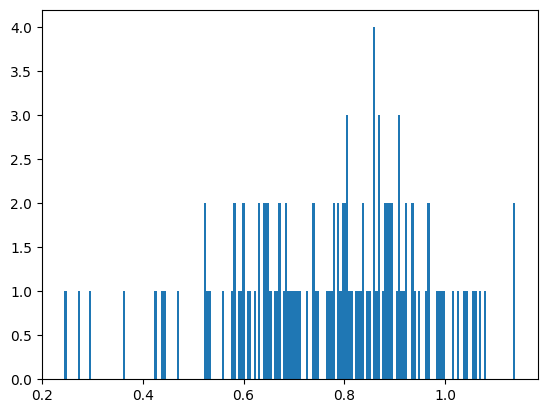

In [8]:
plt.hist(convex_stabilty, bins=200)
plt.show()

Stability transformed: absoluteDISS = |DISS-1| ... and averaged for each epoch. Now only high values indicate stability.

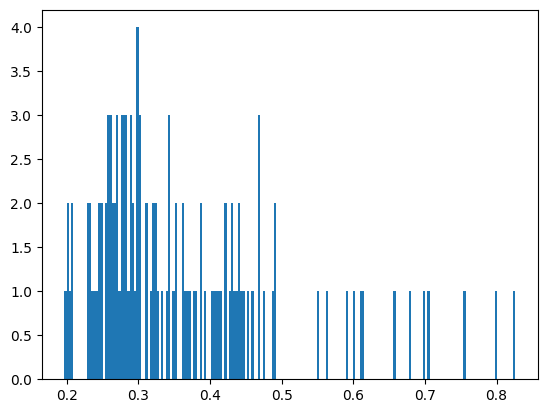

In [9]:
plt.hist(epoched_stability, bins=200)
plt.show()

Average epoch polarity inversion going from gfp peak to gfp peak, meaning DISS < 1.

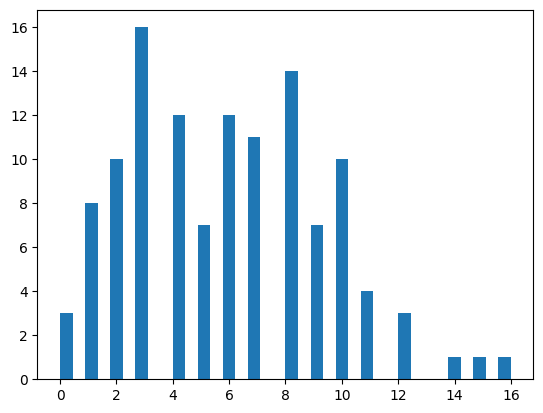

In [10]:
plt.hist(epoched_switching_freq, bins=36)
plt.show()

The same again, but only for shifts in polarity where higher stability is indicated (DISS > 1.4)

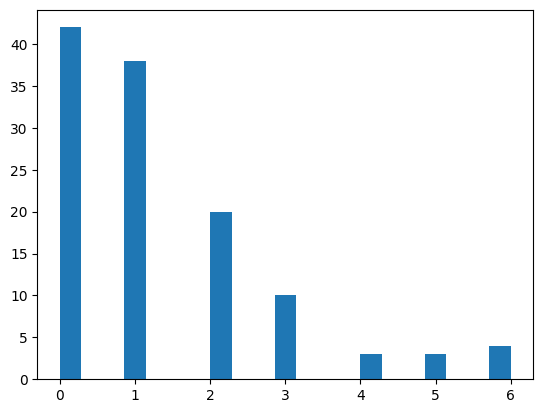

In [11]:
plt.hist(significant_switching_freq, bins=21)
plt.show()

Number of GFP peaks for each epoch

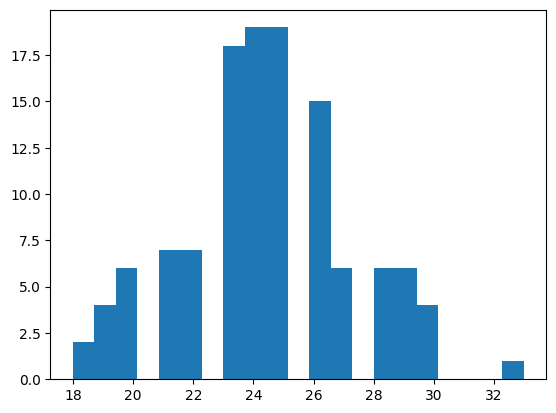

In [12]:
plt.hist(peaks, bins=21)
plt.show()

Looking at scatter plot between swithcing frequencies and number of GFP peaks

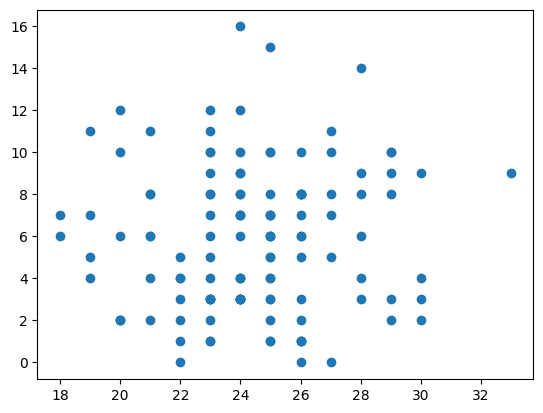

In [13]:
plt.scatter(peaks, epoched_switching_freq)
plt.show()

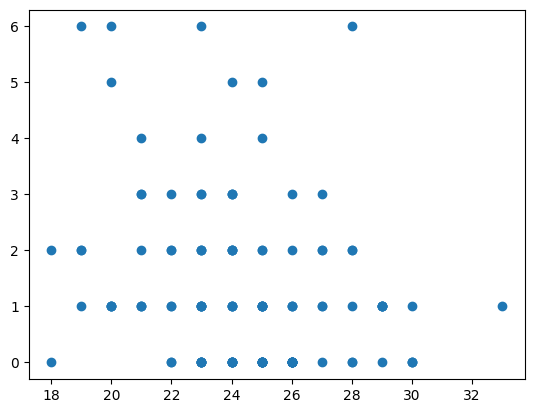

In [14]:
plt.scatter(peaks, significant_switching_freq)
plt.show()

Looking at average absoluteDISS in relation to switching frequencies.

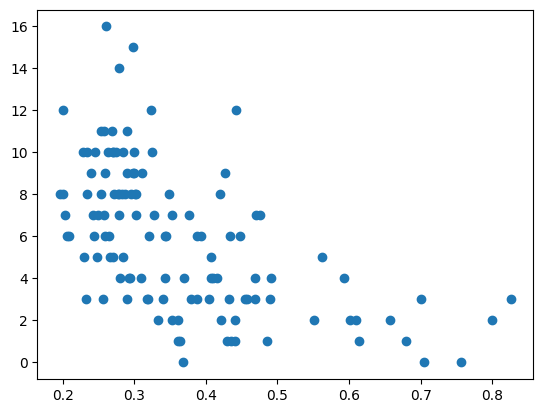

In [15]:
plt.scatter(epoched_stability, epoched_switching_freq)
plt.show()

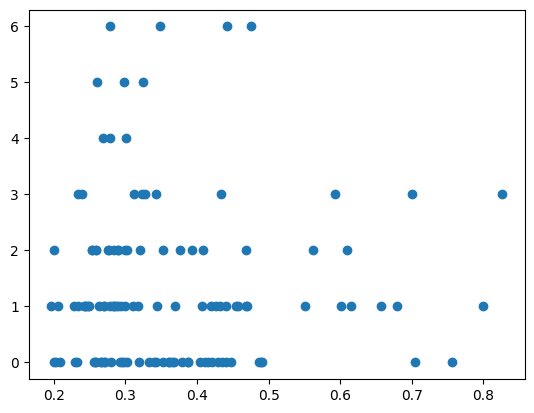

In [16]:
plt.scatter(epoched_stability, significant_switching_freq)
plt.show()

Same but with average DISS

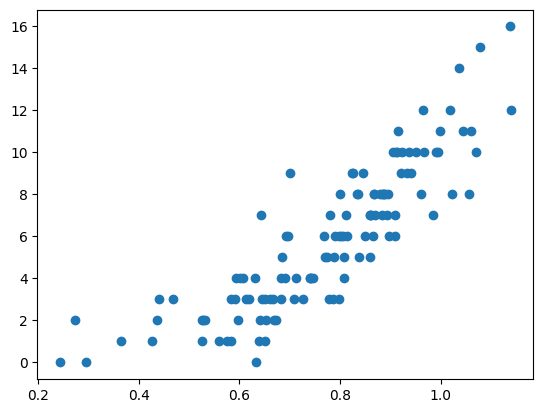

In [17]:
plt.scatter(convex_stabilty, epoched_switching_freq)
plt.show()

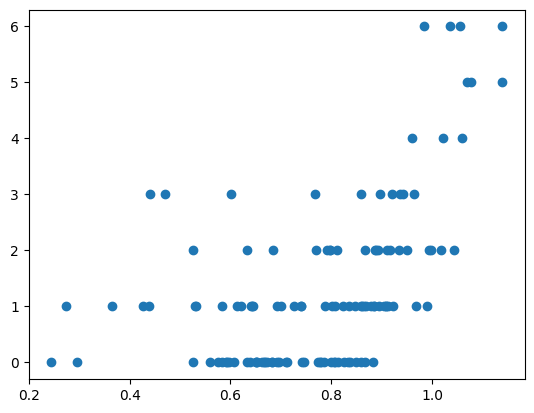

In [18]:
plt.scatter(convex_stabilty, significant_switching_freq)
plt.show()

Scatter of the two stability types

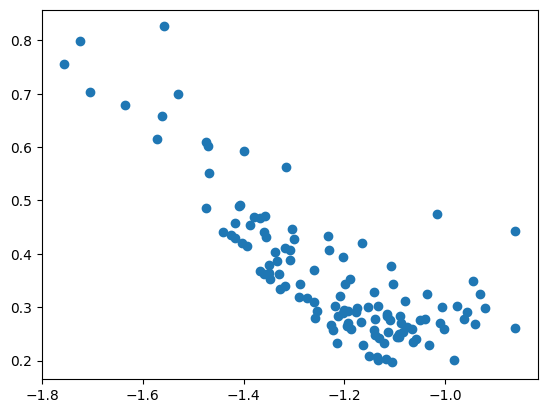

In [19]:
plt.scatter(convex_stabilty-2, epoched_stability)
plt.show()

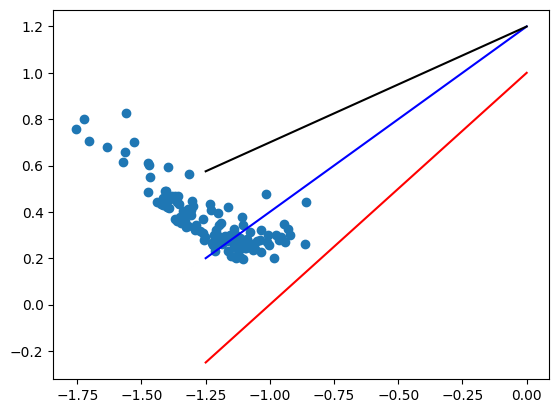

In [20]:
fit = np.poly1d([1, 1])
polyline = np.linspace(-1.25, 0, 100)
reg = np.poly1d([0.8, 1.2])
reg2 = np.poly1d([0.5, 1.2])
plt.scatter(convex_stabilty-2, epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.plot(polyline, reg(polyline), color="blue")
plt.plot(polyline, reg2(polyline), color="black")
plt.show()


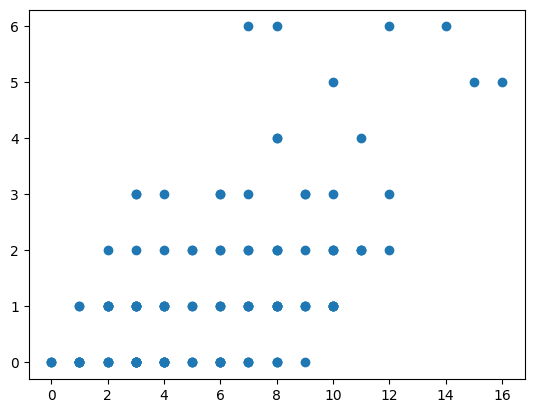

In [21]:
plt.scatter(epoched_switching_freq, significant_switching_freq)
plt.show()

At GFP peaks

In [22]:
at_epoched_stability = stats.peak_stability.get_mean_abs_stab()
at_convex_stabilty = stats.peak_stability.get_mean_stab()

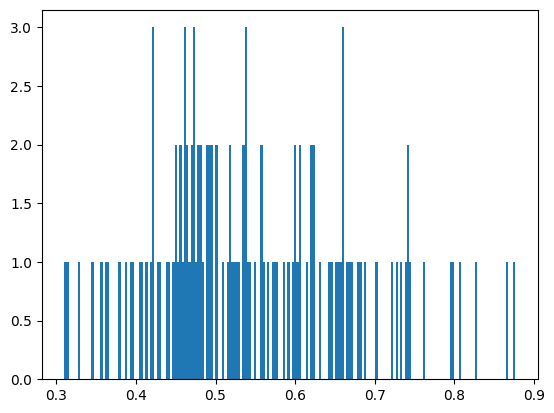

In [23]:
plt.hist(at_epoched_stability, bins=200)
plt.show()

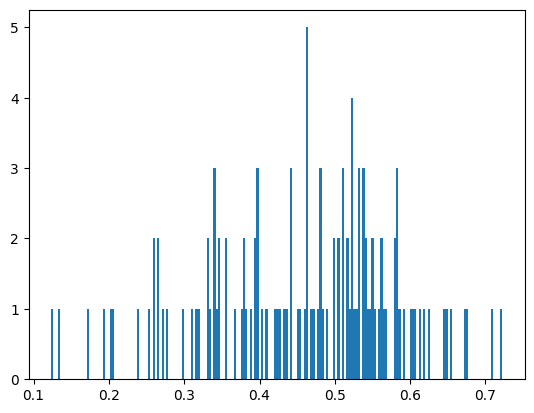

In [24]:
plt.hist(at_convex_stabilty, bins=200)
plt.show()

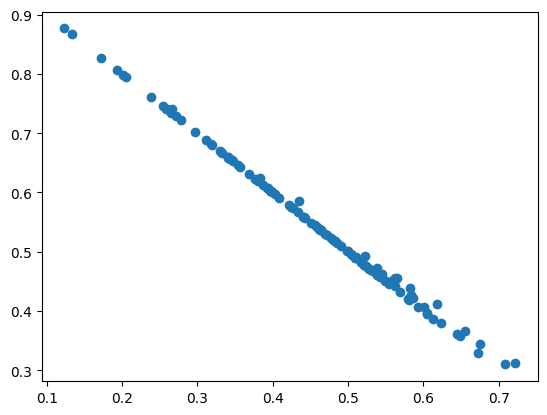

In [25]:
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.show()

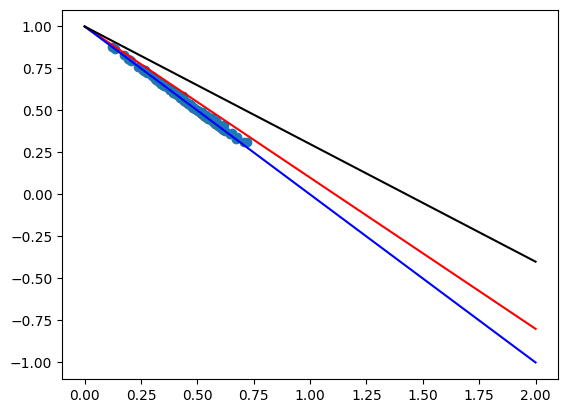

In [26]:
fit = np.poly1d([-0.9, 1])
reg = np.poly1d([-1, 1])
reg2 = np.poly1d([-0.7, 1])
polyline = np.linspace(0, 2, 100)
plt.scatter(at_convex_stabilty, at_epoched_stability)
plt.plot(polyline, fit(polyline), color='red')
plt.plot(polyline, reg(polyline), color="blue")
plt.plot(polyline, reg2(polyline), color="black")
plt.show()

In [27]:
print(fit)

 
-0.9 x + 1


In [28]:
def scale(values):
    v = values.reshape(-1, 1)
    scaler = sklearn.preprocessing.StandardScaler()
    noe = scaler.fit_transform(v)
    return noe

Bad channel evaluation

In [29]:
#ones_epochs.drop_channels('P4')
#ones_epochs.set_eeg_reference()

In [30]:
se_dicts = {
    "peak": {"central": "mean", "spred_corrected": None},
}


In [31]:
stats_channels = channel_stats_new.ChannelStatsNew(
    mne_epochs_object = ones_epochs,
    dist_specifics = se_dicts,
    sklearn_scaler=sklearn.preprocessing.MinMaxScaler()
)

Channel Satbility

At GFP peaks

In [32]:
at_test1 = stats_channels.peak_stab_change
test1 = stats_channels.quasi_stab_change
n_peaks = stats_channels.n_peaks_change

In [33]:
#at_test1 = np.delete(at_test1, 51)
#at_test1 = np.delete(at_test1, 14)
#at_test1 = np.delete(at_test1, 5)
#at_test1 = np.delete(at_test1, 13)

In [34]:
print(at_test1.shape)

(64,)


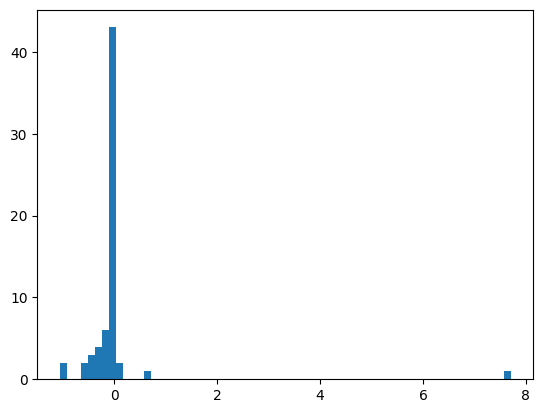

In [35]:
plt.hist(scale(at_test1), bins=64)
plt.show()

In [36]:
order = np.argsort(at_test1)
n = 58
print(skew(at_test1[order][:n]))
print(kurtosis(at_test1[order][:n]))
print(np.array(stats_channels.ch_name_list)[order])

-2.6616825106661546
7.175159867257925
['O1' 'Iz' 'T8' 'O2' 'PO8' 'FT8' 'Oz' 'FC1' 'PO7' 'P10' 'P2' 'Fpz' 'P8'
 'PO3' 'C3' 'CP4' 'C6' 'FC6' 'AF8' 'TP7' 'CP1' 'CP6' 'TP8' 'CP5' 'POz'
 'CP3' 'C4' 'P6' 'F6' 'Pz' 'F3' 'FC5' 'C2' 'P5' 'Fp2' 'FC3' 'FC4' 'C5'
 'P9' 'P3' 'AF4' 'FT7' 'C1' 'F4' 'FCz' 'P7' 'Fp1' 'FC2' 'F8' 'P1' 'F5'
 'Fz' 'CP2' 'AF3' 'CPz' 'F1' 'T7' 'AFz' 'F2' 'AF7' 'Cz' 'F7' 'P4' 'PO4']


In [37]:
print(order[0])

26


Between GFP peaks

In [38]:
plt.hist(scale(scale(test1)), bins=64)
plt.show()

AttributeError: 'NoneType' object has no attribute 'reshape'

In [ ]:
order = np.argsort(test1)
n = 63
print(skew(test1[order][:n]))
print(kurtosis(test1[order][:n]))
print(np.array(stats_channels.ch_name_list)[order])

-0.9883907035733228
2.0945319283921044
['O1' 'T8' 'O2' 'Iz' 'PO8' 'FT8' 'FC1' 'Oz' 'P9' 'C4' 'FC2' 'FC4' 'TP7'
 'FCz' 'F4' 'TP8' 'P8' 'C6' 'FC3' 'FC6' 'Fz' 'Fpz' 'P6' 'AFz' 'F6' 'C5'
 'P10' 'P7' 'T7' 'C1' 'C2' 'F1' 'CP4' 'F3' 'F2' 'AF4' 'AF3' 'P5' 'PO7'
 'CP5' 'F5' 'C3' 'CP1' 'POz' 'AF8' 'FC5' 'FT7' 'Fp1' 'F8' 'P1' 'CP6' 'P2'
 'CPz' 'Pz' 'P3' 'CP3' 'Fp2' 'PO3' 'CP2' 'AF7' 'Cz' 'F7']


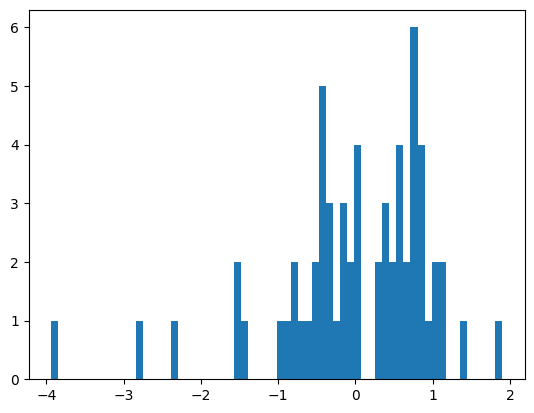

In [ ]:
plt.hist(scale(scale(n_peaks)), bins=64)
plt.show()

In [ ]:
order = np.argsort(n_peaks)
n = 63
print(skew(test1[order][:n]))
print(kurtosis(test1[order][:n]))
print(np.array(stats_channels.ch_name_list)[order])

-0.9883907035733228
2.0945319283921036
['O1' 'P10' 'PO7' 'FT8' 'Fp2' 'P8' 'Iz' 'PO8' 'CP6' 'TP8' 'PO3' 'CP5' 'Pz'
 'CP3' 'AF8' 'P3' 'O2' 'FC6' 'C3' 'Oz' 'FC5' 'AF4' 'C6' 'CP1' 'C5' 'POz'
 'Fpz' 'TP7' 'F8' 'F5' 'T8' 'P2' 'CPz' 'F7' 'F1' 'P6' 'F2' 'C2' 'F3' 'F4'
 'C1' 'P1' 'CP2' 'C4' 'FC2' 'AF3' 'Fp1' 'Fz' 'FT7' 'FC3' 'P7' 'FC4' 'F6'
 'P5' 'AF7' 'AFz' 'Cz' 'CP4' 'FCz' 'T7' 'FC1' 'P9']


test threshold exclusions..

In [ ]:
clean_test = clean_new.CleanNew(ones_epochs, thresholds=[5], dist_specifics=se_dicts)

peak
62
peak
None


In [ ]:
print(clean_test.bad_channel_index)

[62]


In [ ]:
print(ones_epochs.info["ch_names"][58])

P6


In [ ]:
clean_test = clean.Clean(ones_epochs)

In [ ]:
bad_epochs = clean_test.find_bad_epochs(peaks_args={"method": "threshold", "threshold": 0.8, "exclude": "bigger"})

In [ ]:
print(bad_epochs)

(array([  1,   2,   4,   5,   6,   7,   8,  16,  17,  19,  20,  24,  25,
        26,  29,  32,  33,  34,  35,  38,  39,  40,  41,  42,  43,  44,
        45,  46,  47,  52,  53,  54,  56,  57,  58,  59,  60,  61,  62,
        64,  65,  66,  67,  68,  70,  71,  72,  73,  77,  78,  79,  81,
        82,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,
        96,  97,  98,  99, 101, 102, 103, 104, 105, 106, 107, 108, 109,
       110, 111, 112, 113, 114, 115, 116, 117, 118], dtype=int64),)


In [ ]:
bad_epochs = clean_test.find_bad_epochs(peaks_args={"method": "function_threshold", "function": np.poly1d([-1, 1.2]), "exclude":"bigger"})

In [ ]:
print(bad_epochs)

(array([ 29,  45,  82,  91,  97,  99, 101, 106, 108, 113, 114, 115, 116,
       118], dtype=int64),)


PCA heuristic idea

In [ ]:
pc_all_chanels = stats_channels.pca_auc_change

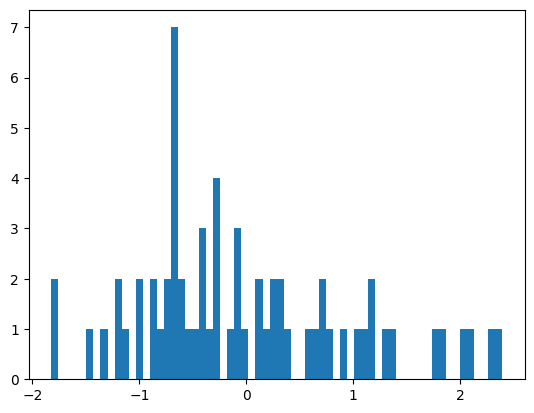

In [ ]:
plt.hist(scale(pc_all_chanels), bins=64)
plt.show()

In [ ]:
order = np.argsort(pc_all_chanels)
print(stats_channels.ch_name_list[order])

['P1' 'POz' 'P2' 'Pz' 'Oz' 'CP1' 'CPz' 'O1' 'Fz' 'C1' 'Fp2' 'F1' 'AF4'
 'P3' 'C2' 'P4' 'Fpz' 'Cz' 'AFz' 'PO3' 'FCz' 'CP2' 'FC1' 'PO8' 'F4' 'CP4'
 'CP3' 'PO7' 'AF8' 'C3' 'P5' 'O2' 'P6' 'C6' 'FC3' 'CP6' 'Iz' 'FC5' 'FC4'
 'C5' 'PO4' 'Fp1' 'C4' 'P10' 'FC6' 'FT7' 'FT8' 'FC2' 'P7' 'AF7' 'P8' 'F6'
 'F8' 'CP5' 'TP8' 'F3' 'F7' 'AF3' 'P9' 'T7' 'F2' 'TP7' 'F5' 'T8']


In [ ]:
bad_by_corr = np.where(pc_all_chanels > 0)[0]
print(stats_channels.ch_name_list[bad_by_corr])

['AF3' 'F3' 'F5' 'F7' 'T7' 'TP7' 'CP5' 'P9' 'F2' 'F6' 'F8' 'T8' 'TP8']


In [ ]:
idx = np.where((at_test1 > 0) & (test1 > 0) & (pc_all_chanels > 0))[0]
print(idx)

[ 5  6 14 15 38 41 51]


In [ ]:
print(stats_channels.ch_name_list[idx])

['F5' 'F7' 'T7' 'TP7' 'F2' 'F8' 'T8']


In [ ]:
idx = np.where((at_test1 > 0) & (pc_all_chanels > 0))[0]
idx2 = np.where((test1 > 0) & (pc_all_chanels > 0))[0]
print(idx)
print(idx2)

[ 2  4  5  6 14 15 38 40 41 51]
[ 5  6 14 15 23 38 41 51]


In [ ]:
print(stats_channels.ch_name_list[idx])
print(stats_channels.ch_name_list[idx2])

['AF3' 'F3' 'F5' 'F7' 'T7' 'TP7' 'F2' 'F6' 'F8' 'T8']
['F5' 'F7' 'T7' 'TP7' 'P9' 'F2' 'F8' 'T8']


Channels to exclude

In [ ]:
acum = []
for cn in stats_channels.ch_name_list[np.argsort(test1)]:
    if cn in stats_channels.ch_name_list[bad_by_corr]:
        print(cn)
        acum.append(cn)
    else:
        break
for cn in stats_channels.ch_name_list[np.argsort(at_test1)]:
    if cn in stats_channels.ch_name_list[bad_by_corr]:
        if cn not in acum:
            print(cn)
    else:
        break


Evaluate

In [ ]:
from data_quality import ica_score

In [ ]:
ones_epochs.set_eeg_reference()
evaluate = ica_score.IcaScore(ones_epochs)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


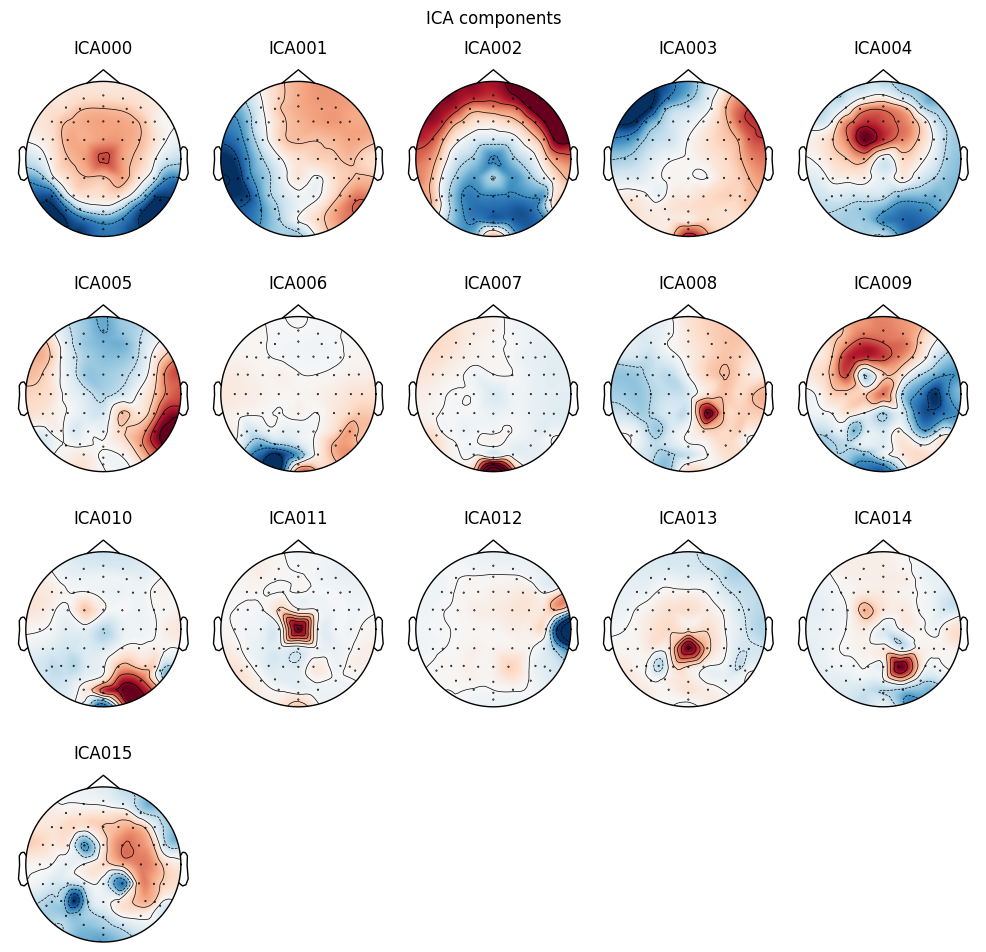

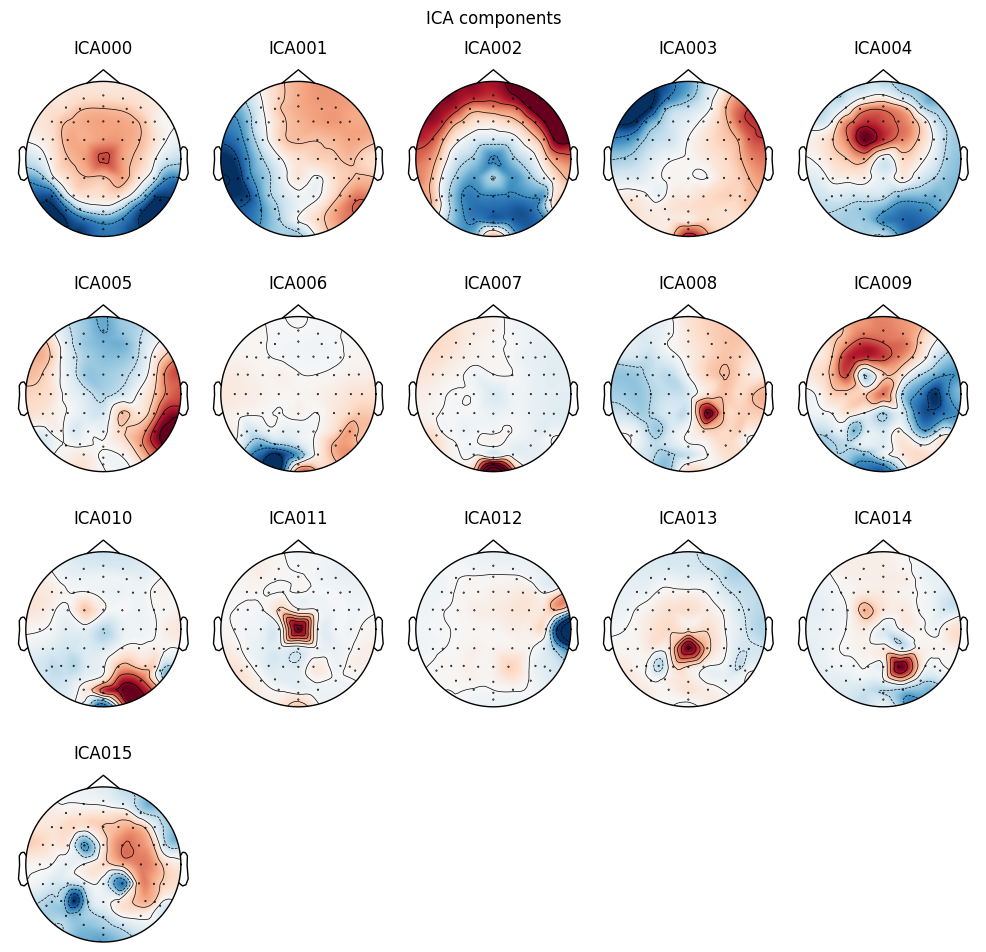

In [ ]:
evaluate.ica.plot_components()

In [ ]:
print(evaluate.ica_labels)

{'y_pred_proba': array([0.9544153 , 0.9954443 , 0.9881996 , 0.54130006, 0.5606645 ,
       0.8622852 , 0.9825746 , 0.6588264 , 0.9853443 , 0.9282139 ,
       0.95190716, 0.45711368, 0.40661827, 0.99930286, 0.75643766,
       0.63692904], dtype=float32), 'labels': ['brain', 'brain', 'brain', 'eye blink', 'other', 'brain', 'muscle artifact', 'brain', 'brain', 'brain', 'muscle artifact', 'other', 'line noise', 'brain', 'muscle artifact', 'brain']}
